In [17]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
from Preprocessing_functions import *
from implementations import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from helpers import load_csv_data

# load data.
data_path = '/Users/nilsmanni/Desktop/MA_3/ML/Proj_1_local/dataset/'
#data_path = './dataset/'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)


## Data Preprocessing ##  

1. Select only the column that might have a correlation to the output (based on personal knowledge and documentation)

In [19]:
selected_columns = [
    "CVDINFR4", "CVDCRHD4", "CVDSTRK3", "BPHIGH4", "TOLDHI2", "DIABETE3",
    "SMOKE100", "SMOKDAY2", "ALCDAY5", "EXERANY2", "FRUIT1", "VEGETAB1",
    "SEX", "AGE", "INCOME2", "EDUCA", "BMI", "GENHLTH", "PHYSHLTH", 
    "MENTHLTH", "POORHLTH", "CHECKUP1", "BPMEDS", "BLOODCHO", "CHOLCHK", 
    "TOLDHI2", "ASTHMA3", "ASTHNOW", "CHCSCNCR", "CHCOCNCR", "CHCCOPD1",
    "ADDEPEV2", "CHCKIDNY", "EMPLOY1", "WEIGHT2", "HEIGHT3", "DIFFWALK",
    "AVEDRNK2", "FVGGREEN", "EXERHMM1", "PREDIAB1", "QLMENTL2", "QLSTRES2",
    "CVDASPRN", "SCNTMNY1"
]

datapath_xtrain = '/Users/nilsmanni/Desktop/MA_3/ML/Proj_1_local/dataset/x_train.csv'
datapath_xtest = '/Users/nilsmanni/Desktop/MA_3/ML/Proj_1_local/dataset/x_test.csv'

# Open the CSV file
with open(datapath_xtrain, newline='', encoding='utf-8') as csvfile:
    # Read the CSV file
    columns_name = csvfile.readline().strip().split(',')

# Indices of the columns to conserve
indices_colonnes = [columns_name.index(col) for col in selected_columns if col in columns_name]
x_train = np.genfromtxt(datapath_xtrain, delimiter=',', skip_header=1, usecols=indices_colonnes, dtype=float)
x_test = np.genfromtxt(datapath_xtest, delimiter=',', skip_header=1, usecols=indices_colonnes, dtype=float)

2. Do the whole pre-processing pipeline with the function "Preprocess_Data"

In [20]:
x_train, x_val, y_train, y_val, x_test_final = Preprocess_Data(
    file_path=data_path,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test, 
    train_size=0.8,                  # Use 20% of data as test set
    missing_val_threshold=0.25,      # Remove columns with >25% missing data
    variance_threshold=0.01,         # Minimum variance threshold
    low_corr_threshold=0.05,         # Minimum correlation threshold with target
    high_corr_threshold=0.9,         # Maximum correlation threshold between features
    p_value_threshold=0.05           # p-value threshold for statistical significance
)

Variance thresholding: 5 features removed with variance below 0.01


## Model Training ##  

We start by converting y_train and y_val to binary values (0,1) instead of (-1,1) in order to compare them to our future predictions.

In [21]:
# Convert y_train and y_val labels to binary (1, 0) for future comparison
y_train_bin = np.where(y_train == -1, 0, 1)
y_val_bin = np.where(y_val == -1, 0, 1)

**1. Gradient Descent method**   

The methods seem to diverge if gamma is above 0.5. Try several number between 0 and 0.5 and keep the best results.

In [22]:
#Gradient descent method: 

gammas = [1e-2, 1e-1, 2e-1, 3e-1]
max_iters_list = [50, 100, 150, 200]

#Best Hyperparameter variables
best_f1 = 0
best_gamma = None
best_max_iters = None
best_loss = None
best_accuracy = None
best_w_GD = None  

training_losses = np.zeros([len(max_iters_list), len(gammas)])

validation_f1 = np.zeros([len(max_iters_list), len(gammas)])
validation_losses = np.zeros([len(max_iters_list), len(gammas)])
validation_accuracies = np.zeros((len(max_iters_list), len(gammas)))

#Test on the different gammas and iterations
for gamma in gammas:
    for max_iters in max_iters_list:
        #Weights initialization
        initial_w = np.zeros((x_train.shape[1]))   

        #Train the model on current hyperparameters
        w, train_loss = mean_squares_error_gd(y_train_bin, x_train, initial_w, max_iters, gamma)

        #Prediction on the validation set
        y_val_pred = np.dot(x_val, w)
        y_val_pred_prob = sigmoid(y_val_pred)
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion to 0 or 1
        
        #F1_score and accuracy calculation on validation set
        f1 = f1_score(y_val_bin, y_val_pred)
    
        accuracy = np.mean(y_val_pred == y_val_bin)
        val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

        training_losses[max_iters_list.index(max_iters), gammas.index(gamma)] = train_loss
        
        validation_f1 [max_iters_list.index(max_iters), gammas.index(gamma)] = f1
        validation_losses[max_iters_list.index(max_iters), gammas.index(gamma)] = val_loss
        validation_accuracies[max_iters_list.index(max_iters), gammas.index(gamma)] = accuracy
        
        #Update the best hyperparameter if the F1_score is higher 
        if f1 > best_f1:
            best_f1 = f1
            best_gamma = gamma
            best_max_iters = max_iters
            best_loss = val_loss
            best_accuracy = accuracy
            best_w_GD = w
            
            
print("Best weights :", best_w_GD) 
print("Best gamma :", best_gamma)
print("Best iteration :", best_max_iters)
print("Best F1 score on validation set :", best_f1)
print("Best accuracy on validation set:", best_accuracy)
print("Best loss on validation :", best_loss)

Best weights : [-0.07902439  0.32359063  0.14498585 -0.0539936   0.2287983   0.16502675
 -0.06379717  0.02667635  0.02569397 -0.00109405 -0.09381263  0.02976883
  0.03252891 -0.00411232 -0.12689506 -0.07678311  0.15270368  0.21336086
 -0.01012044  0.08065328  0.06183255  0.06309705 -0.00925295  0.20694841
  0.11735187  0.05652414 -0.0539936  -0.02160339  0.01702003 -0.05307059
  0.03941854  0.06177202 -0.04931139]
Best gamma : 0.2
Best iteration : 200
Best F1 score on validation set : 0.6865899483325505
Best accuracy on validation set: 0.5394305435720449
Best loss on validation : 0.46056945642795516


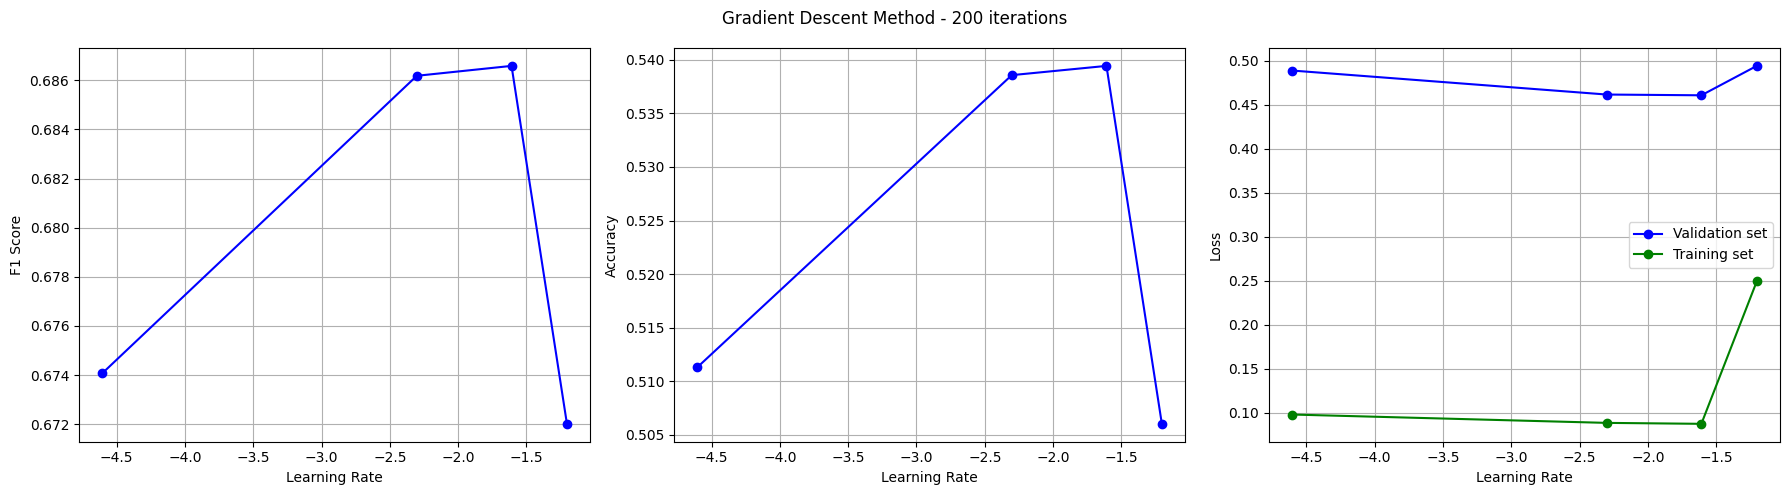

In [23]:
# Get the index for 150 iterations in max_iters_list
iter_index = max_iters_list.index(200)

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot F1 Score
axes[0].plot(np.log(gammas), validation_f1[iter_index, :], marker='o', color='b')
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("F1 Score")
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(np.log(gammas), validation_accuracies[iter_index, :], marker='o', color='b')
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

# Plot Loss
axes[2].plot(np.log(gammas),  validation_losses[iter_index, :], marker='o', color='b', label='Validation set')
axes[2].plot(np.log(gammas),  training_losses[iter_index, :], marker='o', color='g', label ='Training set')
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Loss")
axes[2].grid(True)
axes[2].legend()

# Adjust layout
fig.suptitle('Gradient Descent Method - 200 iterations')
plt.tight_layout()
plt.show()

**Overfitting**: if the training loss keep decreasing but the validation loss start to increase, overfitting is occuring. A significant difference between validation loss and training loss typically indicates overfitting. When the training loss is much lower than the validation loss, it suggests that the model is performing well on the training data but is not generalizing effectively to unseen data, which is characteristic of overfitting.

 **2. Stochastic Gradient Descent method**  

The method does not seem to work for gamma above 0.1. So we selected different gamma between 1e-10 and 0.01. Indeed, the learning rate for the SGD is usually smaller than for GD because, because the weights are updated for each point of the dataset and so it allow to reduce the variations of the weight and converge more rapidly.

In [24]:
gammas = [1e-10, 1e-5, 1e-2]
max_iters = 100

#Best Hyperparameter variables
best_f1 = 0
best_gamma = None
best_max_iters = None
best_loss = None

y_train_bin = np.where(y_train == -1, 0, 1)

training_losses = []

validation_f1 = []
validation_losses = []
validation_accuracies = []

#Test on the different gammas and iterations
for gamma in gammas:
    
    #Weights initialization
    initial_w = np.zeros((x_train.shape[1]))   

    #Train the model on current hyperparameters
    w, train_loss = mean_squared_error_sgd(y_train_bin, x_train, initial_w, max_iters, gamma)

    #Prediction on the validation set
    y_val_pred = np.dot(x_val, w)  
    y_val_prob = sigmoid(y_val_pred)
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion to 0 or 1
    
    #F1_score and accuracy calculation on validation set
    f1 = f1_score(y_val_bin, y_val_pred)

    accuracy = np.mean(y_val_pred == y_val_bin)
    val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

    training_losses.append(train_loss)
        
    validation_f1.append(f1)
    validation_losses.append(val_loss)
    validation_accuracies.append(accuracy)
        
    #Update the best hyperparameter if the F1_score is higher 
    if f1 > best_f1:
        best_f1 = f1
        best_gamma = gamma
        best_max_iters = max_iters
        best_loss = val_loss
        best_accuracy = accuracy
            
            
print("Best gamma :", best_gamma)
print("Best iteration :", best_max_iters)
print("Best F1 score on validation set :", best_f1)
print("Best accuracy on validation set:", best_accuracy)
print("Best loss on validation :", best_loss)

Best gamma : 1e-10
Best iteration : 100
Best F1 score on validation set : 0.6720137496419364
Best accuracy on validation set: 0.506039689387403
Best loss on validation : 0.49396031061259704


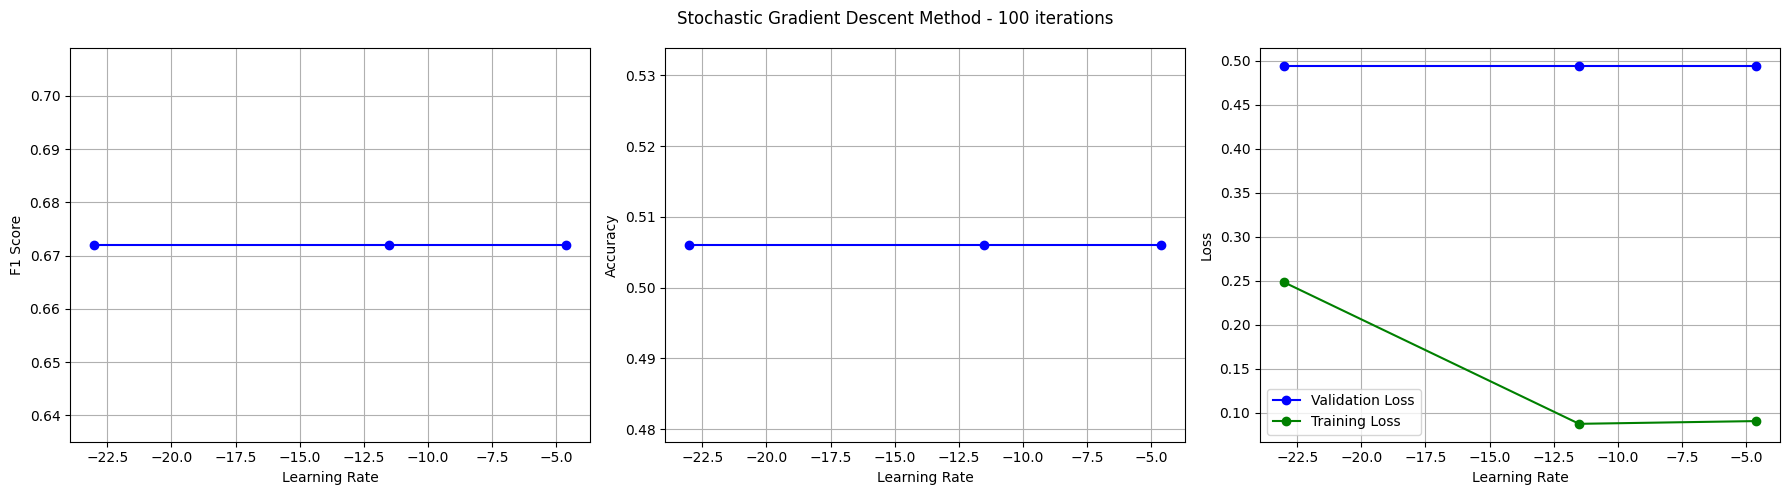

In [25]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot F1 Score
axes[0].plot(np.log(gammas), validation_f1, marker='o', color='b')
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("F1 Score")
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(np.log(gammas), validation_accuracies, marker='o', color='b')
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

# Plot Loss
axes[2].plot(np.log(gammas),  validation_losses, marker='o', color='b', label='Validation Loss')
axes[2].plot(np.log(gammas),  training_losses, marker='o', color='g', label='Training Loss')
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Loss")
axes[2].grid(True)
axes[2].legend()


# Adjust layout
fig.suptitle('Stochastic Gradient Descent Method - 100 iterations')
plt.tight_layout()
plt.show()

The difference between the training and validation loss supposed that overfitting is occuring.

After finding the best parameter for gamma (gamma = 0.01), it is possible to use the method on way more iterations to see if we get better results and if the method converge to a result.

In [26]:
# Initialize parameters
initial_w = np.zeros((x_train.shape[1]))  
max_iters = 500     #increase iteration from 100 to 500
gamma = 1e-10

# Convert y_train and y_test labels to binary (1, 0) for logistic regression
y_train_bin = np.where(y_train == -1, 0, 1)

#Train Stochastic Gradient Descent with MSE
w, loss = mean_squared_error_sgd(y_train_bin, x_train, initial_w, max_iters, gamma)

#Prediction on the validation set
y_val_pred = np.dot(x_val, w)  
y_val_prob = sigmoid(y_val_pred)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion to 0 or 1
    
#F1_score and accuracy calculation on validation set
f1 = f1_score(y_val_bin, y_val_pred)

accuracy = np.mean(y_val_pred == y_val_bin)
val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")

F1 score =0.6720137496419364, Accuracy = 0.506039689387403, Validation loss = 0.49396031061259704


**3. Least Squares Regression Method**

In [27]:
w, loss = least_squares(y_train_bin.reshape(-1, 1), x_train)
print(f"Least squares method : Loss ={loss}")

#Prediction on the validation set
y_val_pred = np.dot(x_val, w)     
#y_val_pred_prob = sigmoid(y_val_pred)      #transform the score into probability between 0 and 1
y_val_pred = (y_val_pred >= 0).astype(int)  
#y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion into binary value

#for the plot: 
train_losses = []
val_losses = []
max_iters = 1000
for iter in range(max_iters):
    w, train_loss = least_squares(y_train_bin.reshape(-1, 1), x_train)
    val_loss = compute_loss(y_val_bin.reshape(-1, 1), x_val, w)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

#F1_score and accuracy calculation on validation set
f1 = f1_score(y_val_bin, y_val_pred)

accuracy = np.mean(y_val_pred == y_val_bin.reshape(-1, 1))
val_loss = np.mean((y_val_pred - y_val_bin.reshape(-1, 1)) ** 2)  # MSE for validation set

print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")

Least squares method : Loss =14.270827825376942
F1 score =0.5417271159765303, Accuracy = 0.5561691113028473, Validation loss = 0.4438308886971527


**4. Ridge Regression Method**

Best lambda is 0.2477076355991709 with a training loss of 0.08695508722845056
Best F1 score = 0.6720137496419364, Accuracy = 0.506039689387403, Validation loss = 0.10267289830893411


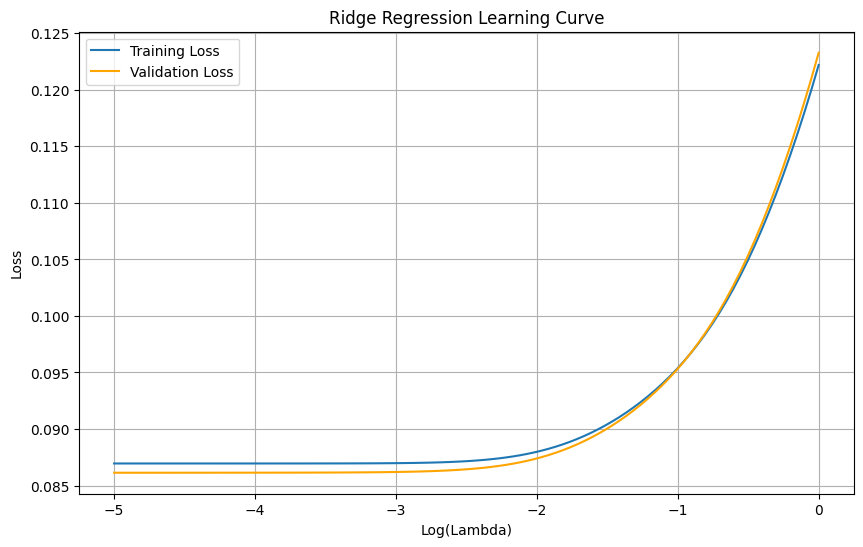

In [28]:
# Range of values for lambda
lambdas_ = np.logspace(-5, 0, 100)

# Initialize lists to store losses
train_losses_ridge = []
val_losses_ridge = []

# Best hyperparameters tracking
best_f1_ridge = 0
best_lambda_ridge = None
best_loss_ridge = None
best_accuracy_ridge = None
best_w_ridge = None  

# Iterate to find the best lambda
for lambda_ in lambdas_:
    # Train the model with the current lambda
    w, train_loss = ridge_regression(y_train_bin.reshape(-1, 1), x_train, lambda_)

    # Calculate validation loss
    val_loss = compute_loss(y_val_bin.reshape(-1, 1), x_val, w)

    # Append losses to their respective lists
    train_losses_ridge.append(train_loss)
    val_losses_ridge.append(val_loss)
    
    # Predictions and metrics on the validation set
    y_val_pred = np.dot(x_val, w)
    y_val_pred = (y_val_pred >= 0).astype(int)
    f1_ridge = f1_score(y_val_bin, y_val_pred)
    accuracy_ridge = np.mean(y_val_pred == y_val_bin.reshape(-1, 1))
    
    # Update best parameters if F1 score improves
    if f1_ridge > best_f1_ridge:
        best_f1_ridge = f1_ridge
        best_lambda_ridge = lambda_
        best_loss_ridge = val_loss
        best_accuracy_ridge = accuracy_ridge
        best_w_ridge = w # Initialize best weights

# Output the best lambda and associated metrics
print(f"Best lambda is {best_lambda_ridge} with a training loss of {min(train_losses_ridge)}")
print(f"Best F1 score = {best_f1_ridge}, Accuracy = {best_accuracy_ridge}, Validation loss = {best_loss_ridge}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lambdas_), train_losses_ridge, label='Training Loss')
plt.plot(np.log10(lambdas_), val_losses_ridge, label='Validation Loss', color='orange')
plt.xlabel('Log(Lambda)')
plt.ylabel('Loss')
plt.title('Ridge Regression Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

**5.Logistic Regression**

In [29]:
# Initialize parameters
initial_w = np.zeros((x_train.shape[1], 1))  # assuming x_train has 38 columns after loading
max_iters = 1000
gamma = 0.01

# Train Logistic Regression
w, loss = logistic_regression(y_train_bin.reshape(-1, 1), x_train, initial_w, max_iters, gamma)

y_val_pred = np.dot(x_val, w) 
y_val_pred_prob = sigmoid(y_val_pred) 
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion into binary value    
f1 = f1_score(y_val_bin, y_val_pred)
accuracy = np.mean(y_val_pred == y_val_bin.reshape(-1, 1))
val_loss = np.mean((y_val_pred - y_val_bin.reshape(-1, 1)) ** 2)  # MSE for validation set

#print(f"Best lambda is {lambda_} with a loss of {loss}")
print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")


F1 score =0.7362258953168044, Accuracy = 0.4999541421340732, Validation loss = 0.5000458578659268


**6. Regularized Logistic Regression**

In [30]:
# Initialize parameters
initial_w = np.zeros((x_train.shape[1], 1))  # assuming x_train has 38 columns after loading
max_iters = 1000
gamma = 0.01
lambda_ = 0.002

# Convert y_train and y_test labels to binary (1, 0) for logistic regression
y_train_bin = np.where(y_train == -1, 0, 1)

# Train Logistic Regression
w, loss = reg_logistic_regression(y_train_bin.reshape(-1, 1), x_train, lambda_, initial_w, max_iters, gamma)

y_val_pred = np.dot(x_val, w) 
y_val_pred_prob = sigmoid(y_val_pred) 
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion into binary value    
f1 = f1_score(y_val_bin, y_val_pred)
accuracy = np.mean(y_val_pred == y_val_bin.reshape(-1, 1))
val_loss = np.mean((y_val_pred - y_val_bin.reshape(-1, 1)) ** 2)  # MSE for validation set

#print(f"Best lambda is {lambda_} with a loss of {loss}")
print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")

F1 score =0.7363980716253444, Accuracy = 0.4999541421340732, Validation loss = 0.5000458578659268


## Test and Prediction ##

We chose to keep the weights from the ridge regression model as it has the overall best F1 score, Accuracy and Validation lost

In [31]:
y_pred_final = (x_test_final @ best_w_ridge >= 0).astype(int).ravel()  # Threshold at 0 for binary
y_pred_final = np.where(y_pred_final == 0, -1, 1)

# Generate ids assuming 1-based indexing
#ids = np.arange(328135, len(x_test) + 328135)

In [32]:
create_csv_submission(test_ids, y_pred_final, 'y_pred_sub')